# Intro

This notebook is part of a series of notebooks that aim to reuse open-source LLM models to perform a binary classification task.

Notebooks can be run completely independently from the others and besides dataset_utils.py have no common local dependencies. (As a result,
you can expect a little bit of code redundancy between notebooks) 

**The task is to detect toxic comments out of text comments retrieved from different news websites.**

For more information, see dataset_utils.py or search for 'Civil Comments dataset' online.

-----
This notebook first loads a model that would be too big for a full fine tuning on a T4 GPU.
It then trains an adapter on this model with the LoRA method.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import evaluate
# AutoModelForSequenceClassification enables us to plus a prtrained model to a classifier head easily
from transformers import (
    pipeline, AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments,
)
from datasets import Value

# [NEW]
from peft import LoraConfig, get_peft_model, TaskType

from utils import dataset_utils

Datasets cache is False


# Load dataset

In [2]:
comments_dataset = dataset_utils.load_sampled_ds(ds_size={
    "train": 1000,  # Adding more on the train split in this notebook, although this is still a bit insufficient to avoid overfitting...
    "validation": 200,
    "test": 200,
})

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [3]:
comments_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 200
    })
})

In [4]:
comments_dataset = (comments_dataset
    .cast_column("is_toxic", Value(dtype='int8'))
    .rename_column("is_toxic", "label") # for trainer
)

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

# Load model

In [5]:
model_name = "google-t5/t5-base" 
# model_name = "google-t5/t5-3b" # ~11GB, T4 only ok for inference

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2 # Binary classification
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# For T5, just to be sure the params will be frozen 
for param in model.transformer.parameters():
    param.requires_grad = False

config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    # Setting a really low rank because our dataset sample is really small to avoid overfitting
    r=16, 
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="none",
    # All modules from the base model will not be trainable besides the ones here
    modules_to_save=["dense", "out_proj"], 
)
model = get_peft_model(model, config)
model.print_trainable_parameters()
# You can compare the number of parameters to the size of our training set, which
# suggest we could very easily overfit

trainable params: 2,361,602 || all params: 225,857,284 || trainable%: 1.0456


In [ ]:
# Have a look at how the Lora wrapper modified our model structure
model

In [7]:
# Setup dataset batches
comments_dataset = comments_dataset.map(
    lambda example: tokenizer(example["text"], padding=True, truncation=True), batched=True
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [8]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss to correct for imbalance
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 10.0]).to(self.model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [9]:
training_args = TrainingArguments(
    "classifier-lora-trainer",
    report_to="none",
    num_train_epochs=5.0,
    save_strategy="no", # Low disk space, don't save checkpoints, esp w big models
    eval_strategy="epoch",
    learning_rate=0.001,
    logging_strategy="epoch",
    per_device_train_batch_size=16,
)


trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=comments_dataset["train"],
    eval_dataset=comments_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipykernel_79298/688873167.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


[2024-11-01 15:37:24,876] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/home/ray/anaconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.4
 [WARNING]  using untested triton version (3.0.0), only 1.0.0 is known to be compatible


/home/ray/anaconda3/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:49: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/ray/anaconda3/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/ray/anaconda3/lib/python3.10/site-packages/mlflow/tracking/context/registry.py:63: UserWarning: Failure attempting to register context provider "hendrix-run-context": cannot import name 'create_experiment' from partially initialized module 'mlflow' (most likely due to a circular import) (/home/ray/anaconda3/lib/python3.10/site-packages/mlflow/__init__.py)
  _run_context_provider_registry.register_entrypoints()
/home/ray/anaconda3/lib/python3.10/site-packages/m

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.946000,0.916389
2,0.591900,0.530846
3,0.376000,0.478748
4,0.215000,0.762155


KeyboardInterrupt: 

# Global evaluation and Threshold selection


In [12]:
def softmax(predictions):
    # Subtract the max for numerical stability
    exp_preds = np.exp(predictions)
    return exp_preds / np.sum(exp_preds, axis=1)[..., np.newaxis]

# Would benefit using a map method instead
for split in ["train", "validation", "test"]:
    comments_dataset[split] = comments_dataset[split].add_column(
        "toxic_score",
        softmax(trainer.predict(comments_dataset[split]).predictions[0])[:, 1]
    )

In [13]:
# Eval ROC_AUC on train and valid
roc_auc_score = evaluate.load("roc_auc")
for split in ["train", "validation"]:
    auc_score = roc_auc_score.compute(
        references=comments_dataset[split]['label'],
        prediction_scores=comments_dataset[split]["toxic_score"]
    )
    print(
        f"{split} ROC_AUC: {auc_score}"
    )

train ROC_AUC: {'roc_auc': 0.9937873873873875}
validation ROC_AUC: {'roc_auc': 0.9167517875383043}


Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

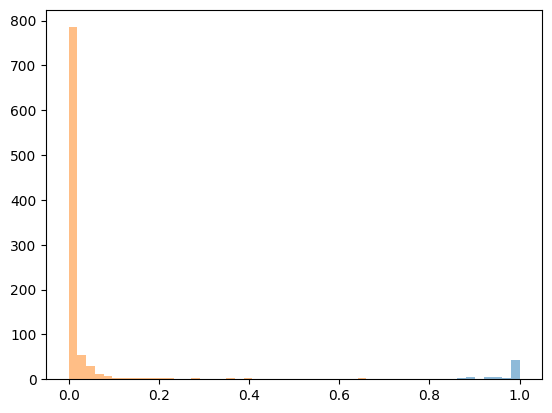

In [14]:
plt.hist(comments_dataset["train"].filter(lambda example:example["label"])["toxic_score"], bins=50, alpha=0.5)
plt.hist(comments_dataset["train"].filter(lambda example:not example["label"])["toxic_score"], bins=50, alpha=0.5)
plt.show()

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

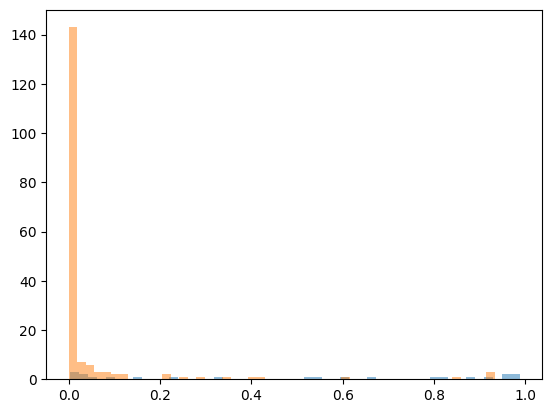

In [15]:
# Check calibrations of predictions and pick threshold manually if needed
plt.hist(comments_dataset["validation"].filter(lambda example:example["label"])["toxic_score"], bins=50, alpha=0.5)
plt.hist(comments_dataset["validation"].filter(lambda example:not example["label"])["toxic_score"], bins=50, alpha=0.5)
plt.show()

# Evaluation with selected threshold

In [16]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
PROB_THRESHOLD = 0.3


In [17]:

# To check for overfitting
clf_metrics.compute(
    references=comments_dataset["train"]["label"],
    predictions=[score > PROB_THRESHOLD for score in comments_dataset["train"]["toxic_score"]]
)

{'accuracy': 0.98,
 'f1': 0.8749999999999999,
 'precision': 0.8235294117647058,
 'recall': 0.9333333333333333}

In [18]:
clf_metrics.compute(
    references=comments_dataset["validation"]["label"],
    predictions=[score > PROB_THRESHOLD for score in comments_dataset["validation"]["toxic_score"]]
)

{'accuracy': 0.915,
 'f1': 0.6046511627906977,
 'precision': 0.6190476190476191,
 'recall': 0.5909090909090909}

# Final Test

In [19]:
# When you're happy with your tuning, run the evaluation on the test set and report your results on the sheet!
clf_metrics.compute(
    references=comments_dataset["test"]["label"],
    predictions=[score > PROB_THRESHOLD for score in comments_dataset["test"]["toxic_score"]]
)

{'accuracy': 0.94,
 'f1': 0.5384615384615384,
 'precision': 0.5,
 'recall': 0.5833333333333334}

# Considerations post training
use `merge_and_unload()` to merge your adapter back to the base model! (Speeds up loading and inference)